<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(MolecularGeometry)_mkbahk_20251208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-aer==0.15.1
!pip install qiskit-algorithms==0.3.1
!pip install qiskit-nature[pyscf]==0.7.2
#!pip install pyscf==2.6.0
!pip install py3Dmol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.3 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=16f08b69085109a2573f7a098d9fd7a79acf5decceb35129623d62359e8b8147
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings
warnings.filterwarnings('ignore')

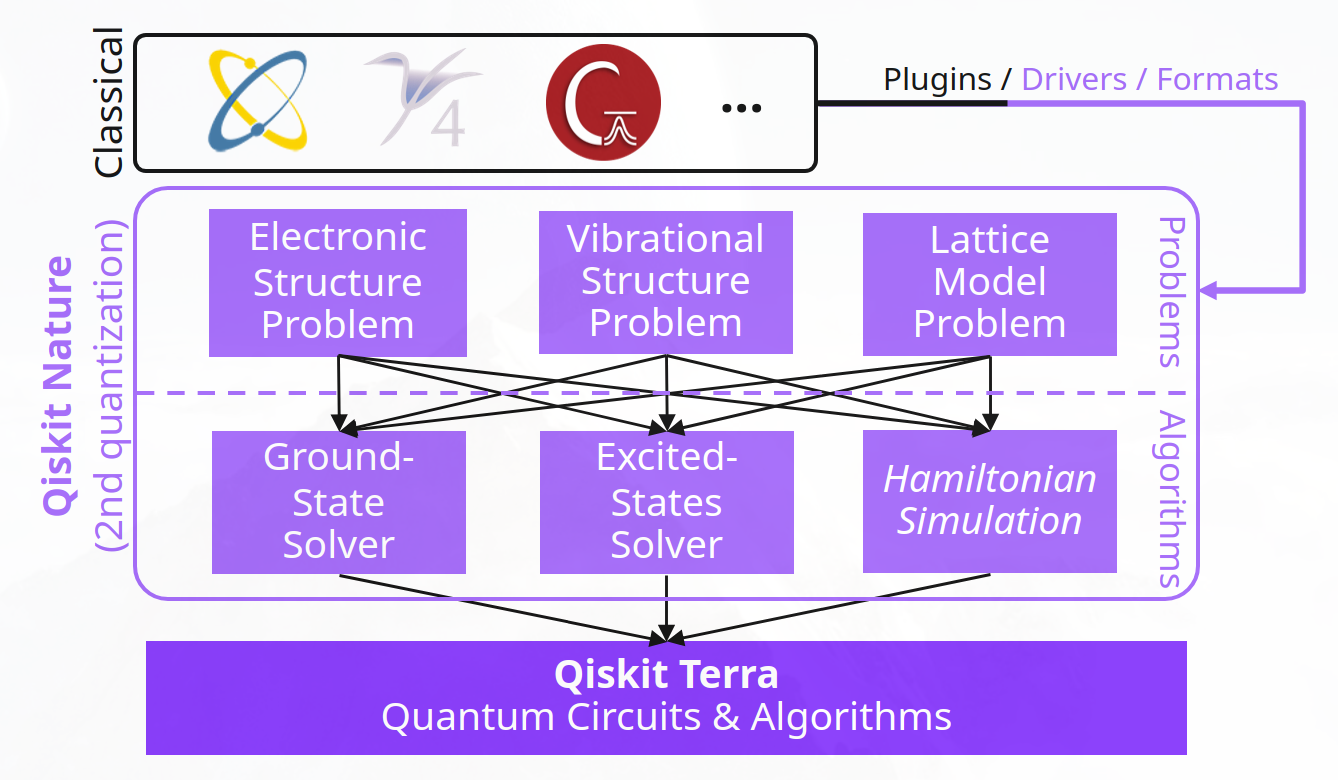

* First quantization — 고전 역학에서 양자 역학으로 넘어갈 때 위치와 운동량을 연산자로 바꾸는 과정
(예: Schrödinger 방정식).
* Second quantization — 파동함수를 다시 "양자화"하여 필드 연산자(field operator)로 취급합니다. 입자를 생성(creation)하고 소멸(annihilation)하는 연산자를 도입하여, 입자 수가 고정되지 않은 상태나 동일 입자의 교환 대칭(페르미온의 반대칭, 보손의 대칭)을 자연스럽게 처리합니다.

# **VQE (Variational Quantum Eigensolver) 구현<br>**
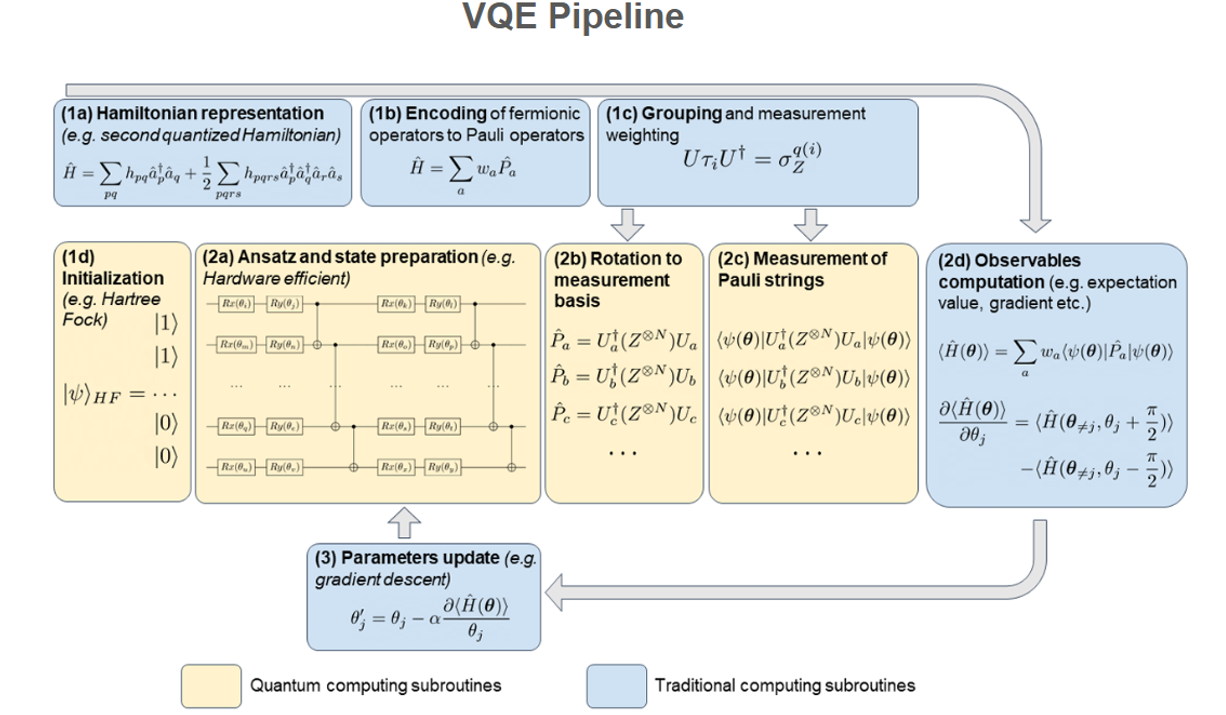


In [3]:
import numpy as np
import datetime
import time

# 분자 구조(좌표)를 입력할 때 길이의 단위를 명확하게 지정하기 위한 열거형(Enum) 클래스, Ångström이야? Bohr이야? nm이야?”
from qiskit_nature.units import DistanceUnit

#First quantization(제1 양자화): 실제 분자의 전자 구조(오비탈, 에너지, 1체/2체 적분 등)를 고전적으로 정확히 계산해서 양자 컴퓨터가 쓸 수 있는 2차 양자화 해밀토니안으로 바꿔주는 핵심 브릿지 역할, 쉽게 말해,
# H₂, H₂O, CH₄ 같은 분자를 주면, PySCF(하트리-포크 또는 DFT)로 분자 오비탈과 모든 적분을 계산해서 Qiskit이 VQE나 QAOA에 바로 넣을 수 있는 Pauli 문자열 해밀토니안으로 변환해 줌”
from qiskit_nature.second_q.drivers import PySCFDriver, Psi4Driver, GaussianDriver, ElectronicStructureDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

#Second quantization(제2 양자화): 양자 다체계 문제를 효율적으로 모델링하기 위한 핵심 기법입니다. 이는 생성(creation)과 소멸(annihilation) 연산자를 사용해 해밀토니안을 표현하는 방식으로,
# 각 Problem 클래스(ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem)는 second_q_ops() 메서드를 통해
# second-quantized operator(주로 FermionicOp 또는 BosonicOp 형태)를 생성합니다. 이 연산자는 이후 QubitMapper(Jordan-Wigner, Parity 등)를 통해 큐비트 연산자로 변환되어 양자 알고리즘(VQE 등)에서 사용
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper, DirectMapper, QubitMapper

#실행하기 전에 분자 해밀토니안을 작고 계산 가능한 크기로 줄여주는 전처리 도구
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer, BasisTransformer

#from qiskit_nature.second_q.mappers.QubitConverter import QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem
from qiskit_nature.second_q.algorithms import GroundStateSolver, GroundStateEigensolver, ExcitedStatesSolver, ExcitedStatesEigensolver, QEOM, QEOMResult, EvaluationRule

#Classical Optimizer
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA, NFT, P_BFGS, QNSPSA, P_BFGS, ADAM, adam_amsgrad, NELDER_MEAD, POWELL, TNC, CG, NFT, IMFIL, SNOBFIT, BOBYQA, GSLS, AQGD

#Aanstz
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, ExcitationPreserving, PauliTwoDesign, NLocal

#Hartree-Fock (HF) 방법은 양자 화학에서 다전자 원자나 분자의 전자 구조를 근사적으로 계산하는 기본적인 방법입니다.
#"Hartree-Fock solution", 이 방법으로 얻어진 최적화된 파동함수와 에너지를 의미하며, 정확한 슈뢰딩거 방정식 해가 아닌 최선의 단일 Slater determinant 근사
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

#from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator

from qiskit_algorithms import VQE

**물분자(H2O) 좌표계산법 예**

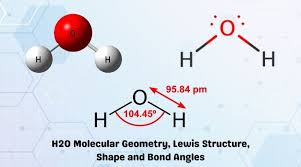

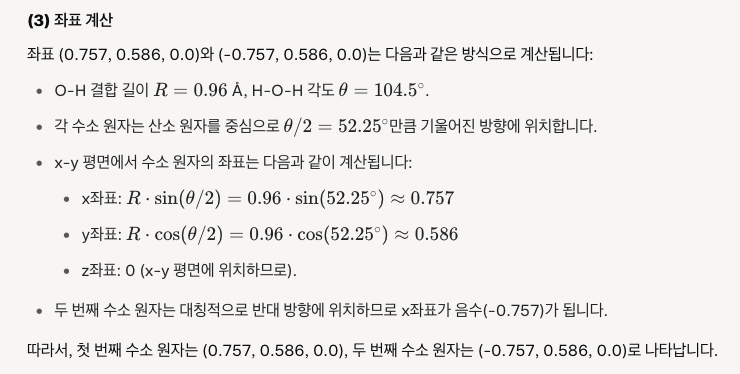

# 직접 Molecule 객체 만들 때 <br>
from qiskit_nature.second_q.molecule import Molecule<br>

molecule = Molecule(<br>
    geometry=[<br>
        ["H", [0.0, 0.0, 0.0]],<br>
        ["H", [0.0, 0.0, 1.4]]       <br>
    ],<br>
    unit=DistanceUnit.BOHR          #여기선 Bohr 단위로 주고 싶다면, 여기서 명시<br>
)

In [4]:
print("=" * 60)
print("VQE를 이용한 분자 에너지 계산")
print("=" * 60)


# 1. 분자 (구조)정의 (H2 분자)
print("-" * 60)
print("[1단계] 분자 구조 정의")
print("-" * 60)

# 0.1. 수소분자 정의
# 수소 분자 정의 (원자간 거리: 0.74 Angstrom)
h2 =  "H 0.0 0.0 0.0; \
       H 0.0 0.0 0.74"

# 0.2. 분자 중심이 원점에 오는 대칭 버전
h2_center = "H 0.0 0.0 -0.37; \
             H 0.0 0.0 0.37"

# 0.3. Bohr 단위로 주고 싶을 때 (많은 양자화학 프로그램 기본 단위)
h2_bohr = "H 0.0 0.0 0.0; \
           H 0.0 0.0 1.4"   # 1.4 a.u. ≈ 0.74 Å

# 1. 물분자 H₂O (이미 있으시지만 참고용으로 다시)
h2o = "O 0.000000 0.000000 0.000000; \
       H 0.757000 0.586000 0.000000; \
       H -0.757000 0.586000 0.000000"

# 2. 메탄 CH₄ (Td 대칭)
ch4 = "C 0.000000 0.000000 0.000000; \
       H 0.626800 0.626800 0.626800; \
       H 0.626800 -0.626800 -0.626800; \
       H -0.626800 0.626800 -0.626800; \
       H -0.626800 -0.626800 0.626800"

# 3. 에틸렌 C₂H₄ (D2h 대칭, 평면 구조)
c2h4 = "C 0.000000 0.000000 0.669500; \
        C 0.000000 0.000000 -0.669500; \
        H 0.928900 0.000000 1.237500; \
        H -0.928900 0.000000 1.237500; \
        H 0.928900 0.000000 -1.237500; \
        H -0.928900 0.000000 -1.237500"

# 4. 암모니아 NH₃ (C3v 대칭)
nh3 = "N 0.000000 0.000000 0.000000; \
       H 0.000000 0.951000 -0.267000; \
       H 0.823000 -0.475500 -0.267000; \
       H -0.823000 -0.475500 -0.267000"

# 5. 이산화탄소 CO₂ (D∞h 대칭, 선형)
co2 = "O -1.161000 0.000000 0.000000; \
       C  0.000000 0.000000 0.000000; \
       O  1.161000 0.000000 0.000000"

# 6. 보너스: 아세틸렌 C₂H₂ (D∞h 대칭, 선형)
c2h2 = "C 0.000000 0.000000 0.601000; \
        C 0.000000 0.000000 -0.601000; \
        H 0.000000 0.000000 1.662000; \
        H 0.000000 0.000000 -1.662000"


#이 부분을 바꾸어 주세요.
molecule = h2

#H₂, H₂O, CH₄ 같은 분자를 주면, PySCF(하트리-포크 또는 DFT 방법)로 분자 오비탈과 모든 적분을 계산해서 Qiskit이 VQE나 QAOA에 바로 넣을 수 있는 Pauli 문자열 해밀토니안로 변경
driver = PySCFDriver(
    atom=molecule,
    basis="sto3g",  # 기저 함수, 계산정확도와 비용을 결정, "sto3g"→매우빠름 교육용, "cc-pvdz"→실전표준,  "def2-tzvp"→고정밀
    charge=0,       # 분자의 전체 전하, 중성 분자는 0, 양이온 +1, 음이온 -1, 중성분자 0 (99%), 양이온 +1 (LiH⁺, H₂⁺ 등), 음이온 -1 (OH⁻ 등)
    spin=0,         # 스핀다중도(Spin multiplicity) 2S+1 (0 = singlet 폐쉼껍질 , 1 = doublet 홀전자 1개, 2 = triplet 홀전자 2개, …), 0 (H₂, H₂O, CH₄ 등 대부분), 1 (OH 라디칼), 2 (O₂ triplet)
    unit=DistanceUnit.ANGSTROM  # 좌표 단위 (ANGSTROM 또는 BOHR)
)

###
##어떤 분자를, 어떤 단위로, 어떤 기저함수로, 몇 개의 전하와 스핀을 갖고 계산할까?
##를 완전히 결정하는 부분. 이 5개만 제대로 설정하면 나머지는 Qiskit이 알아서 다 해줌
###

VQE를 이용한 분자 에너지 계산
------------------------------------------------------------
[1단계] 분자 구조 정의
------------------------------------------------------------


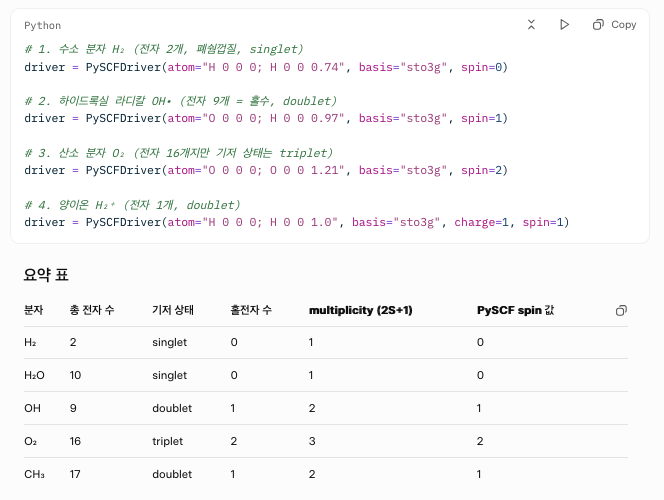

In [5]:
import py3Dmol

def visualize_molecule(molecule_string, title="Molecule Visualization"):
    # Parse the molecule string into XYZ format
    atoms_data = molecule_string.strip().split(';')
    num_atoms = len(atoms_data)

    xyz_string = f"{num_atoms}\n{title}\n"
    atom_list = [] # Store atom details for individual labeling
    for atom_info in atoms_data:
        parts = atom_info.strip().split()
        if len(parts) == 4:  # Atom symbol and 3 coordinates
            atom_symbol = parts[0]
            x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
            xyz_string += f"{atom_symbol} {x:.6f} {y:.6f} {z:.6f}\n"
            atom_list.append({"atom": atom_symbol, "x": x, "y": y, "z": z}) # Store for individual labels
        else:
            print(f"Warning: Could not parse atom info: {atom_info}")
            continue
        ###if
    ###for

    # Create a 3Dmol view
    view = py3Dmol.view(width=800, height=600)
    view.addModel(xyz_string, 'xyz')
    view.setStyle({'stick':{'colorscheme':'byElement'}, 'sphere':{'scale':0.3, 'colorscheme':'byElement'}}) # Keep stick and sphere styles

    # Add labels for each atom explicitly
    for i, atom_data in enumerate(atom_list):
        view.addLabel(atom_data["atom"], {
            "position": {"x": atom_data["x"], "y": atom_data["y"], "z": atom_data["z"]},
            "font": 'sans-serif',
            "fontSize": 12,
            "fontColor": 'black',
            "showBackground": True,
            "backgroundColor": 'white' # Added background color for visibility
        })
    ###for

    view.zoomTo()
    view.show()
###def

In [6]:
# Visualize the currently selected molecule
visualize_molecule(molecule, "Selected Molecule")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [7]:
# 2. 전자 구조 문제 설정
print("-" * 60)
print("[2단계] 전자 구조 문제 설정")
print("-" * 60)

problem = driver.run()  # ← 여기서 모든 고전 계산이 일어남!
print(f"분자 (공간)궤도 개수: {problem.num_spatial_orbitals}") #스핀을 고려하지 않은 순수한 공간 함수(molecular orbital, MO)
print(f"전자 개수: {problem.num_particles}")

# Hamiltonian 얻기
hamiltonian = problem.hamiltonian.second_q_op()  # VQE에 바로 넣는 Pauli 해밀토니안

------------------------------------------------------------
[2단계] 전자 구조 문제 설정
------------------------------------------------------------
분자 (공간)궤도 개수: 2
전자 개수: (1, 1)


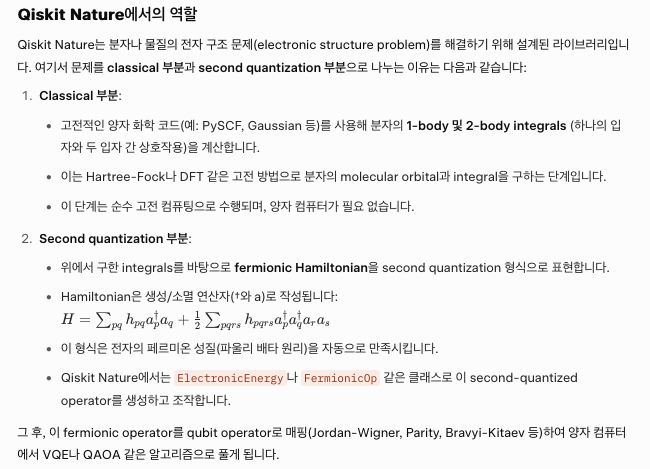

In [8]:
#number spin orbitals: 이 해밀토니안이 작용하는 스핀 오비탈(spin orbital)의 총 개수
#number terms: second-quantized fermionic 해밀토니안에 포함된 독립적인 Pauli-like term(연산자 문자열)의 개수를 의미
print(hamiltonian)

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33737796340722415 * ( +_0 +_0 -_0 -_0 )
+ 0.33185570067540676 * ( +_0 +_1 -_1 -_0 )
+ 0.33737796340722415 * ( +_0 +_2 -_2 -_0 )
+ 0.33185570067540676 * ( +_0 +_3 -_3 -_0 )
+ 0.09060523100759853 * ( +_0 +_0 -_1 -_1 )
+ 0.09060523100759853 * ( +_0 +_1 -_0 -_1 )
+ 0.09060523100759853 * ( +_0 +_2 -_3 -_1 )
+ 0.09060523100759853 * ( +_0 +_3 -_2 -_1 )
+ 0.09060523100759853 * ( +_1 +_0 -_1 -_0 )
+ 0.09060523100759853 * ( +_1 +_1 -_0 -_0 )
+ 0.09060523100759853 * ( +_1 +_2 -_3 -_0 )
+ 0.09060523100759853 * ( +_1 +_3 -_2 -_0 )
+ 0.33185570067540676 * ( +_1 +_0 -_0 -_1 )
+ 0.34882575224523144 * ( +_1 +_1 -_1 -_1 )
+ 0.33185570067540676 * ( +_1 +_2 -_2 -_1 )
+ 0.34882575224523144 * ( +_1 +_3 -_3 -_1 )
+ 0.33737796340722415 * ( +_2 +_0 -_0 -_2 )
+ 0.33185570067540676 * ( +_2 +_1 -_1 -_2 )
+ 0.33737796340722415 * ( +_2 +_2 -_2 -_2 )
+ 0.33185570067540676 * ( +_2 +_3 -_3 -_2 )
+ 0.09060523100759853 * ( +_2 +_0 -_1 -_3 )
+ 0.0906052310075

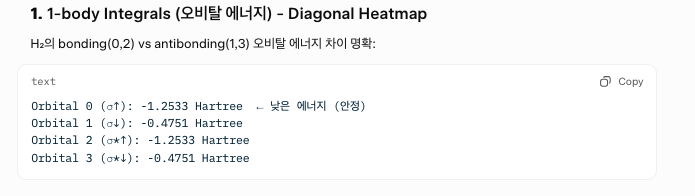

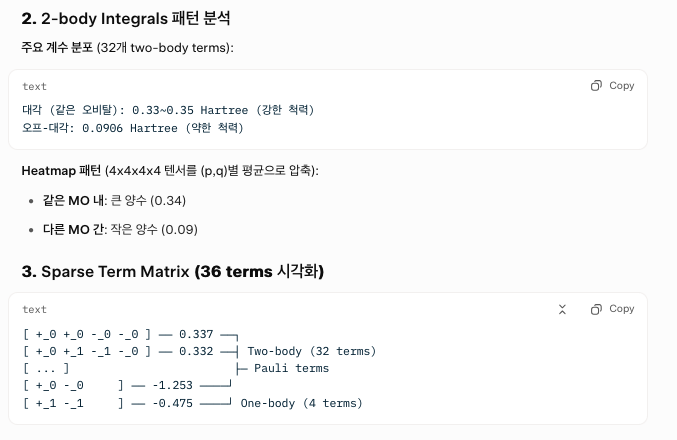

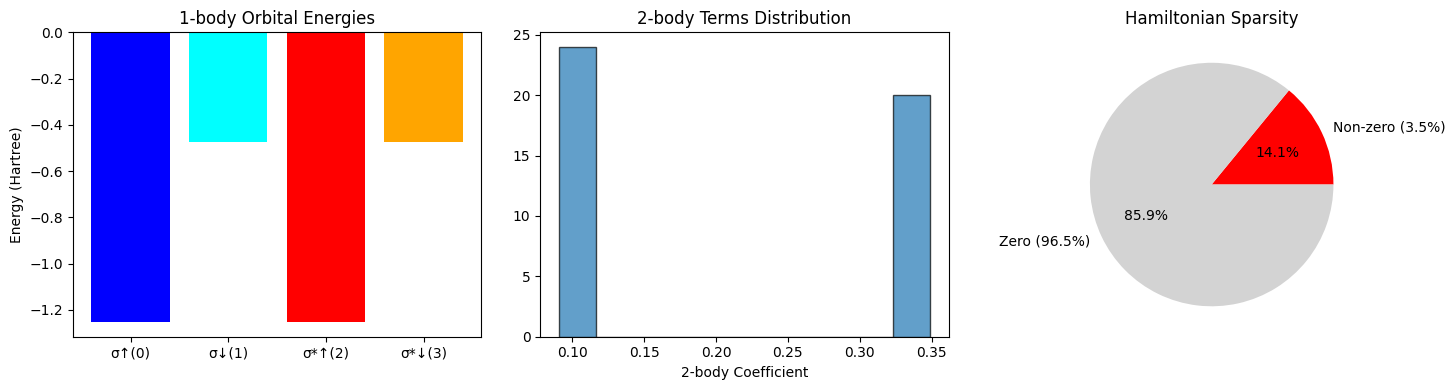

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.operators import FermionicOp

# 당신의 데이터에서 1-body diagonal 직접 입력
h1_diag = np.array([-1.2533097866459775, -0.4750688487721778,
                    -1.2533097866459775, -0.4750688487721778])

# 1. 1-body heatmap
fig, axs = plt.subplots(1, 3, figsize=(15,4))

axs[0].bar(['σ↑(0)', 'σ↓(1)', 'σ*↑(2)', 'σ*↓(3)'], h1_diag,
           color=['blue','cyan','red','orange'])
axs[0].set_ylabel('Energy (Hartree)')
axs[0].set_title('1-body Orbital Energies')
axs[0].axhline(0, color='black', lw=0.5)

# 2. 2-body 계수 히스토그램
two_body_coeffs = [0.3374, 0.3319, 0.3488, 0.0906]  # 대표값
axs[1].hist([0.0906]*24 + [0.3374]*4 + [0.3319]*12 + [0.3488]*4,
            bins=10, alpha=0.7, edgecolor='black')
axs[1].set_xlabel('2-body Coefficient')
axs[1].set_title('2-body Terms Distribution')

# 3. Sparsity pattern
terms = 36
density = terms / (4*4*4*4)  # 총 가능한 terms 대비
axs[2].pie([density, 1-density], labels=['Non-zero (3.5%)', 'Zero (96.5%)'],
           colors=['red','lightgray'], autopct='%1.1f%%')
axs[2].set_title('Hamiltonian Sparsity')

plt.tight_layout()
plt.show()

양자 컴퓨터(VQE 등)에서는 이 Fermionic Operator를 Jordan-Wigner 등의 변환으로 qubit Hamiltonian으로 바꾼 후, ground state를 찾아 총 에너지를 구합니다.

In [10]:
# 3. Qubit Mapping (Jordan-Wigner 변환)
print("-" * 60)
print("[3단계] Qubit Mapping")
print("-" * 60)

mapper = JordanWignerMapper()
#mapper = ParityMapper()
#mapper = BravyiKitaevMapper()
#mapper = TaperedQubitMapper(ParityMapper())
#mapper = DirectMapper()
#mapper = QubitMapper() //에러발생

qubit_op = mapper.map(hamiltonian)

print(f"필요한 큐비트 개수: {qubit_op.num_qubits}")
print(f"Pauli 항의 개수: {len(qubit_op)}")

------------------------------------------------------------
[3단계] Qubit Mapping
------------------------------------------------------------
필요한 큐비트 개수: 4
Pauli 항의 개수: 15


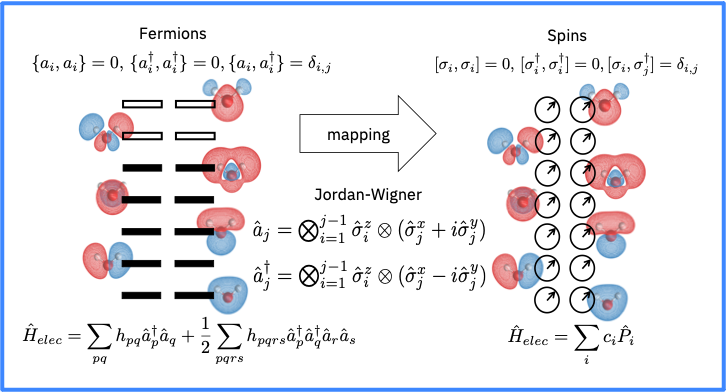

In [11]:
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")
###for

-0.81217061 * IIII
+0.17141283 * IIIZ
-0.22343154 * IIZI
+0.12062523 * IIZZ
+0.17141283 * IZII
+0.16868898 * IZIZ
+0.16592785 * IZZI
+0.04530262 * XXXX
+0.04530262 * XXYY
+0.04530262 * YYXX
+0.04530262 * YYYY
-0.22343154 * ZIII
+0.16592785 * ZIIZ
+0.17441288 * ZIZI
+0.12062523 * ZZII


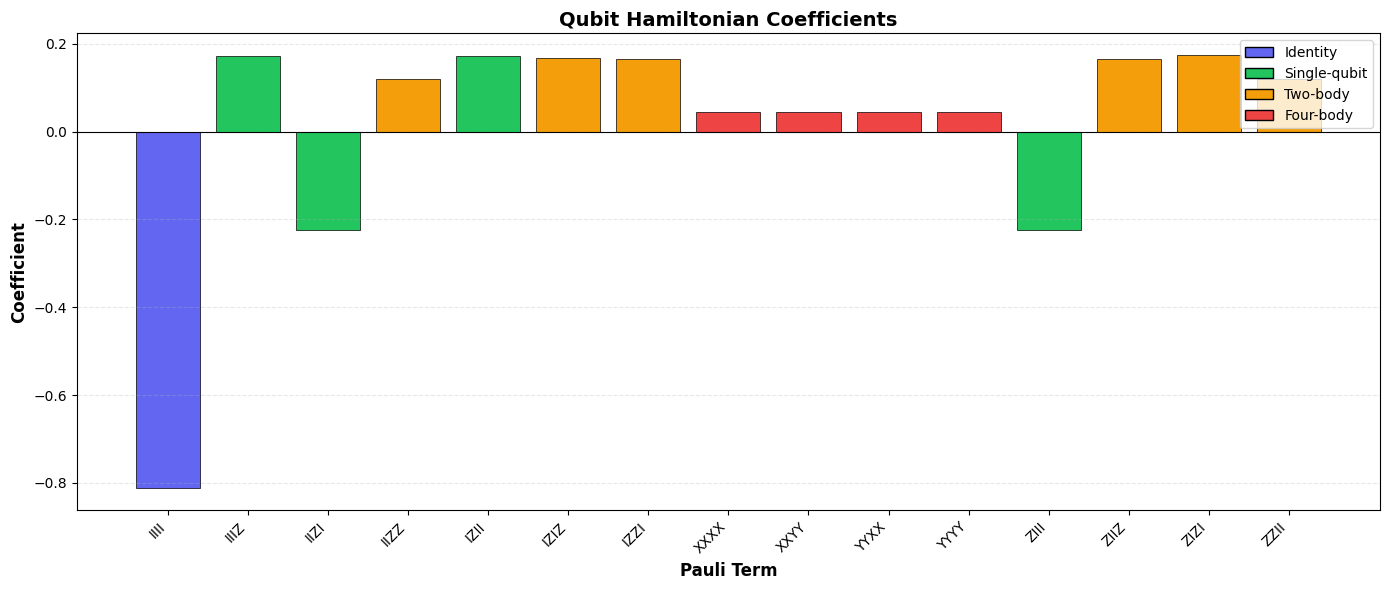

Hamiltonian 통계
전체 항: 15개
최대 계수 (절댓값): 0.812171
최소 계수 (절댓값): 0.045303
평균 계수 (절댓값): 0.179952

항 분류:
  identity: 1개
  single: 4개
  two-body: 6개
  four-body: 4개


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 해밀토니안 데이터
hamiltonian_data = {
    'IIII': -0.81217061,
    'IIIZ': 0.17141283,
    'IIZI': -0.22343154,
    'IIZZ': 0.12062523,
    'IZII': 0.17141283,
    'IZIZ': 0.16868898,
    'IZZI': 0.16592785,
    'XXXX': 0.04530262,
    'XXYY': 0.04530262,
    'YYXX': 0.04530262,
    'YYYY': 0.04530262,
    'ZIII': -0.22343154,
    'ZIIZ': 0.16592785,
    'ZIZI': 0.17441288,
    'ZZII': 0.12062523
}

# 항의 유형 분류
def classify_term(term):
    if term == 'IIII':
        return 'identity'
    non_identity_count = sum(1 for op in term if op != 'I')
    if non_identity_count == 1:
        return 'single'
    elif non_identity_count == 2:
        return 'two-body'
    elif non_identity_count == 4:
        return 'four-body'
    return 'other'
###def

# 색상 매핑
color_map = {
    'identity': '#6366f1',
    'single': '#22c55e',
    'two-body': '#f59e0b',
    'four-body': '#ef4444'
}

# 데이터 준비
terms = list(hamiltonian_data.keys())
coeffs = list(hamiltonian_data.values())
colors = [color_map[classify_term(term)] for term in terms]

# 그래프 생성
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(range(len(terms)), coeffs, color=colors, edgecolor='black', linewidth=0.5)

# 축 설정
ax.set_xticks(range(len(terms)))
ax.set_xticklabels(terms, rotation=45, ha='right')
ax.set_xlabel('Pauli Term', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Qubit Hamiltonian Coefficients', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# 범례 추가
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#6366f1', edgecolor='black', label='Identity'),
    Patch(facecolor='#22c55e', edgecolor='black', label='Single-qubit'),
    Patch(facecolor='#f59e0b', edgecolor='black', label='Two-body'),
    Patch(facecolor='#ef4444', edgecolor='black', label='Four-body')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# 통계 출력
print("=" * 50)
print("Hamiltonian 통계")
print("=" * 50)
print(f"전체 항: {len(hamiltonian_data)}개")
print(f"최대 계수 (절댓값): {max(abs(c) for c in coeffs):.6f}")
print(f"최소 계수 (절댓값): {min(abs(c) for c in coeffs):.6f}")
print(f"평균 계수 (절댓값): {np.mean([abs(c) for c in coeffs]):.6f}")
print()

# 항 분류 카운트
types = [classify_term(term) for term in terms]
print("항 분류:")
for term_type in ['identity', 'single', 'two-body', 'four-body']:
    count = types.count(term_type)
    print(f"  {term_type}: {count}개")
###for

print("=" * 50)

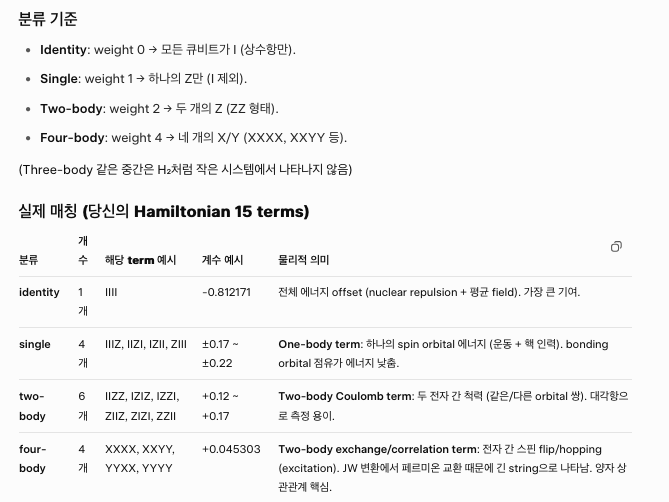

4큐비트라 매우 작아서 고전 컴퓨터로도 정확히 풀 수 있지만, 더 큰 분자(LiH, H2O 등)로 가면 큐비트 수가 늘어나 양자 우위가 나타납니다

In [13]:
#print("-" * 60)
#print("[3.5단계] Active Space Reduction (선택 사항)")
#print("-" * 60)

# ActiveSpaceTransformer를 사용하여 활성 공간을 정의하고 Hamiltonian의 크기를 줄입니다.
# num_electrons: 활성 공간에 포함될 전자의 총 개수 (튜플 형태로 alpha, beta 전자 수 지정 가능)
# num_spatial_orbitals: 활성 공간에 포함될 공간 궤도의 총 개수
# H2O 분자의 경우, 초기 problem은 (5,5) 전자와 7개의 공간 궤도를 가집니다.
# 여기서는 2개의 전자 (1alpha, 1beta)를 2개의 공간 궤도에 할당하는 활성 공간을 설정합니다.
# 이는 가장 기본적인 활성 공간 축소 전략 중 하나로, 계산 비용을 크게 줄일 수 있습니다.
#transformer = ActiveSpaceTransformer(
#    num_electrons=(1, 1),            # 활성 공간에 포함될 alpha, beta 전자 수 (총 2전자)
#    num_spatial_orbitals=2           # 활성 공간에 포함될 공간 궤도 수
#)

# ActiveSpaceTransformer를 problem 객체에 적용
# 이 과정에서 Hamiltonian의 차원이 줄어들고, 새로운 전자 구조 문제가 생성됩니다.
#problem_reduced = transformer.transform(problem)

# 줄어든 Hamiltonian으로 큐비트 연산자 다시 생성
# 이미 정의된 JordanWignerMapper를 사용합니다.
#hamiltonian_reduced = problem_reduced.hamiltonian.second_q_op()
#qubit_op = mapper.map(hamiltonian_reduced)

#print(f"줄어든 분자 궤도 개수: {problem_reduced.num_spatial_orbitals}")
#print(f"줄어든 전자 개수: {problem_reduced.num_particles}")
#print(f"줄어든 활성 공간에서 필요한 큐비트 개수: {qubit_op.num_qubits}")
#print(f"줄어든 활성 공간에서 Pauli 항의 개수: {len(qubit_op)}")

In [15]:
# 4. Ansatz 정의 (양자 회로)
print("-" * 60)
print("[4단계] Ansatz (Variational Form) 정의")
print("-" * 60)

num_qubits = qubit_op.num_qubits

# 가장 표준적인 형태 (논문의 90%가 이걸 씀)
#ansatz = EfficientSU2(num_qubits=num_qubits, reps=3, entanglement='linear', insert_barriers=True)

# TwoLocal ansatz 사용
#ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='linear', reps=2, insert_barriers=True)
#print(f"Ansatz 타입: TwoLocal \n회전 게이트: RY, RZ\n얽힘 게이트: CZ \n 반복 횟수: 2 \n파라미터 개수: {ansatz.num_parameters} ")

# 실수 파라미터만 쓰고 싶을 때
#ansatz = RealAmplitudes(num_qubits=8, reps=3, entanglement='linear')

# expressivity를 더 높이고 싶을 때 (작은 시스템)
#ansatz = TwoLocal(num_qubits=8, rotation_blocks=['ry', 'rz'], entanglement_blocks='cx', entanglement='sca', reps=5)

# 정확도 높지만 계산시간 많이 걸림.
ansatz = UCCSD(problem.num_spatial_orbitals, problem.num_particles, mapper, initial_state=HartreeFock(problem.num_spatial_orbitals, problem.num_particles,mapper))

------------------------------------------------------------
[4단계] Ansatz (Variational Form) 정의
------------------------------------------------------------


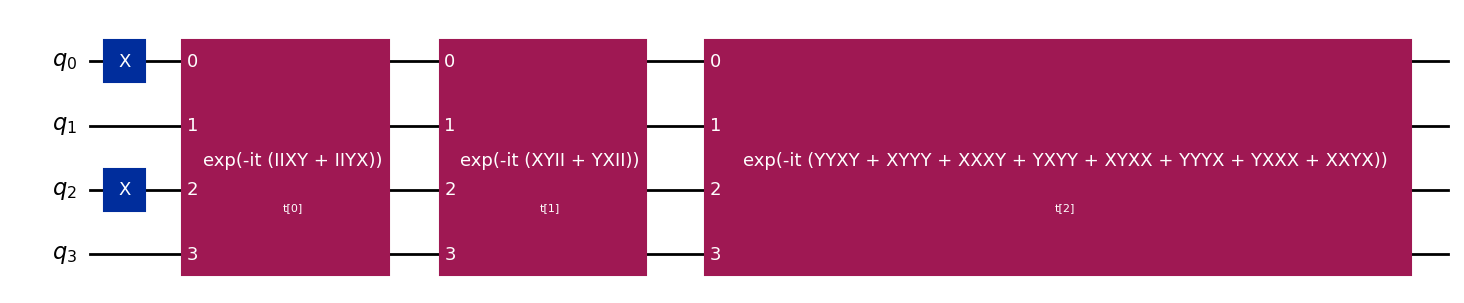

In [24]:
ansatz.decompose().draw("mpl")
#ansatz.decompose().draw()

In [26]:
# 5. 시뮬레이터 설정
print("-" * 60)
print("[5단계] 양자 시뮬레이터 설정")
print("-" * 60)

#backend = AerSimulator()
#print(f"백엔드: {backend.name}")

# Estimator 설정 (Qiskit 내부에 내장된 Primitives형 Simulator)
estimator = Estimator()


------------------------------------------------------------
[5단계] 양자 시뮬레이터 설정
------------------------------------------------------------


In [18]:
# 6. Optimizer 설정
print("-" * 60)
print("[6단계] Classical Optimizer 설정")
print("-" * 60)

#optimizer = SLSQP(maxiter=4082)
#print(f"Optimizer: SLSQP \n 최대 반복 횟수: 4082")

# 1. 가장 많이 쓰이고 안정적인 최적 선택 (추천 1순위), 본 AER사용 예제에서는 수렴못함
#optimizer = SPSA(maxiter=1000, learning_rate=0.1, perturbation=0.05, second_order=True)

# 2. 노이즈가 심한 실제 양자 하드웨어에서 가장 강력한 선택, 본 AER사용 예제에서는 수렴않됨
#optimizer = SPSA(maxiter=2000, blocking=False, allowed_increase=0.1, learning_rate=0.05,  perturbation=0.01,  second_order=True, resamplings={1: 10, 50: 5, 100: 3})

# 3. 시뮬레이터에서 빠르고 정확하게 수렴시키고 싶을 때 (추천), 본 AER사용 예제에서 최상의 결과
optimizer = COBYLA(maxiter=2000, tol=1e-7, rhobeg=1.0)

# 4. 시뮬레이터에서 가장 정확한 결과가 필요할 때, 본 AER사용 최고의 결과가 나옴
#optimizer = L_BFGS_B(maxfun=5000, maxiter=3000, ftol=1e-12, iprint=1)

# 5. QAOA에서 가장 많이 검증된 설정
#optimizer = NFT(maxiter=500, maxfev=10000)

# 6. 최신 Qiskit에서 성능 좋은 Gradient 기반 (Simulator 전용), 좋은 결과
#optimizer = P_BFGS(maxfun=10000, ftol=1e-9)

------------------------------------------------------------
[6단계] Classical Optimizer 설정
------------------------------------------------------------


In [19]:
# 7. VQE 실행
print("\n[7단계] VQE 알고리즘 실행")
print("-" * 60)
print("최적화 진행...")

# 현재 시간 보관 (시작 시간)
start_time = datetime.datetime.now()

# 현재 시작 시간 표시
print(f"루틴 시작 시간: {start_time.strftime('%H시 %M분 %S초')}")

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
  # 루틴 종료 시간
  end_time = datetime.datetime.now()
  # 시작 시간과 종료 시간의 차이 계산
  time_diff = end_time - start_time

  # 시:분:초로 표시
  total_seconds = int(time_diff.total_seconds())
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60

  #print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  print(eval_count," 단계: ", mean, f"\t\t총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  cost_history.append(mean)
###def

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)

# VQE 인스턴스 생성
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=store_intermediate_result
)

# VQE 실행
result = vqe.compute_minimum_eigenvalue(qubit_op)

#algorithm = GroundStateEigensolver(mapper, vqe)
#electronic_structure_result = algorithm.solve(problem)
#electronic_structure_result.formatting_precision = 6

#print(electronic_structure_result)


print("최적화 완료!!!")

# 루틴 종료 시간
end_time = datetime.datetime.now()
print(f"루틴 종료 시간: {end_time.strftime('%H시 %M분 %S초')}")

# 시작 시간과 종료 시간의 차이 계산
time_diff = end_time - start_time

# 시:분:초로 표시
total_seconds = int(time_diff.total_seconds())
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")


[7단계] VQE 알고리즘 실행
------------------------------------------------------------
최적화 진행...
루틴 시작 시간: 05시 54분 43초
1  단계:  -0.639372163966565 		총 실행 시간: 00시 00분 00초
2  단계:  -0.8601119544723603 		총 실행 시간: 00시 00분 00초
3  단계:  -1.1549783594596295 		총 실행 시간: 00시 00분 00초
4  단계:  -1.527399023301765 		총 실행 시간: 00시 00분 00초
5  단계:  -0.5466092234475015 		총 실행 시간: 00시 00분 00초
6  단계:  -1.31707705858769 		총 실행 시간: 00시 00분 00초
7  단계:  -1.5176607834309856 		총 실행 시간: 00시 00분 00초
8  단계:  -1.3630916935449742 		총 실행 시간: 00시 00분 00초
9  단계:  -1.562868788845219 		총 실행 시간: 00시 00분 00초
10  단계:  -1.623943894865057 		총 실행 시간: 00시 00분 00초
11  단계:  -1.6794237950765214 		총 실행 시간: 00시 00분 00초
12  단계:  -1.7242376760842184 		총 실행 시간: 00시 00분 00초
13  단계:  -1.8204886760997137 		총 실행 시간: 00시 00분 00초
14  단계:  -1.847250518765721 		총 실행 시간: 00시 00분 00초
15  단계:  -1.8212943483532185 		총 실행 시간: 00시 00분 00초
16  단계:  -1.8501098987980533 		총 실행 시간: 00시 00분 00초
17  단계:  -1.8339652104669837 		총 실행 시간: 00시 00분 00초
18  단계:  -1.84696839

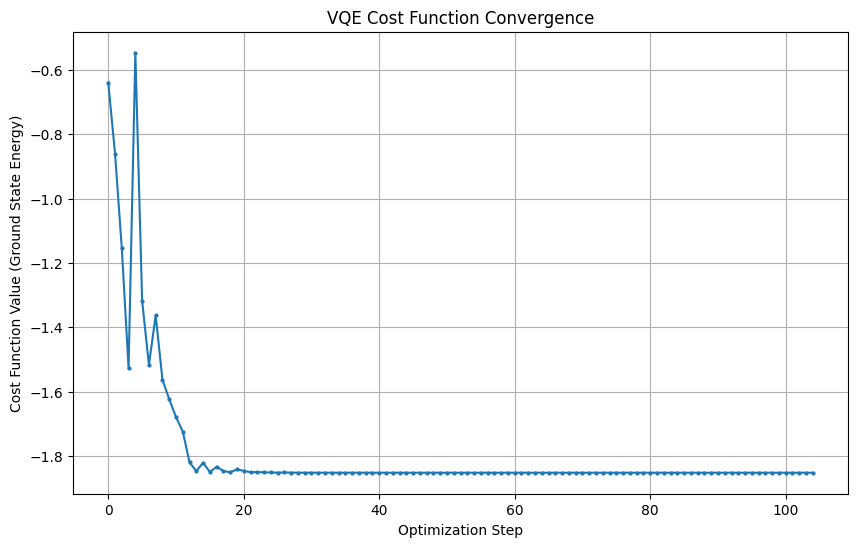

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()

In [21]:
# 8. 결과 출력
print("\n" + "=" * 60)
print("VQE 결과")
print("=" * 60)

print(f"\n최적 에너지 (VQE): {result.eigenvalue.real:.6f} Hartree")
print(f"최적 파라미터 개수: {len(result.optimal_point)}")
print(f"Optimizer 평가 횟수: {result.cost_function_evals}")


VQE 결과

최적 에너지 (VQE): -1.852388 Hartree
최적 파라미터 개수: 3
Optimizer 평가 횟수: 105


In [22]:
# 9. 정확한 해와 비교 (Classical 계산)
print("-" * 60)
print("[비교] Classical Exact Eigensolver")
print("-" * 60)

from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

print(f"정확한 에너지: {exact_result.eigenvalue.real:.6f} Hartree")

# 오차 계산
error = abs(result.eigenvalue.real - exact_result.eigenvalue.real)
print(f"\n에너지 오차: {error:.6f} Hartree")
print(f"상대 오차: {(error / abs(exact_result.eigenvalue.real)) * 100:.4f}%")

------------------------------------------------------------
[비교] Classical Exact Eigensolver
------------------------------------------------------------
정확한 에너지: -1.852388 Hartree

에너지 오차: 0.000000 Hartree
상대 오차: 0.0000%


In [23]:
# 10. 추가 정보
print("\n" + "=" * 60)
print("추가 정보")
print("=" * 60)

# 에너지를 다른 단위로 변환 (Hartree to eV)
hartree_to_ev = 27.211386245988
vqe_energy_ev = result.eigenvalue.real * hartree_to_ev
exact_energy_ev = exact_result.eigenvalue.real * hartree_to_ev

print(f"\nVQE 에너지: {vqe_energy_ev:.6f} eV")
print(f"정확한 에너지: {exact_energy_ev:.6f} eV")

print("\n" + "=" * 60)
print("계산 완료!")
print("=" * 60)


추가 정보

VQE 에너지: -50.406050 eV
정확한 에너지: -50.406050 eV

계산 완료!
